In [2]:
sc.install_pypi_package("boto3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [3]:
import boto3
import matplotlib
from pyspark.sql.functions import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
s3 = boto3.resource('s3')
bucket = 'lsc-sentiments'
bucket_resource = s3.Bucket(bucket)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
data = spark.read.json('s3://lsc-sentiments')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 12
Total Rows: 342
root
 |-- anger: string (nullable = true)
 |-- date: string (nullable = true)
 |-- disgust: string (nullable = true)
 |-- fear: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- id: string (nullable = true)
 |-- joy: string (nullable = true)
 |-- others: string (nullable = true)
 |-- sadness: string (nullable = true)
 |-- sentiment: struct (nullable = true)
 |    |-- results: string (nullable = true)
 |-- surprise: string (nullable = true)
 |-- tweet: string (nullable = true)

In [19]:
data[['date', 'anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise', 'geo']].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+-------+------+------+------+-------+--------+--------------------+
|               date| anger|disgust|  fear|   joy|others|sadness|surprise|                 geo|
+-------------------+------+-------+------+------+------+-------+--------+--------------------+
|2021-12-05 17:30:43|0.0712| 0.0143|0.0154|0.0778| 0.615| 0.1417|  0.0646|20.6597,-103.3496...|
|2021-12-02 17:23:22|0.0149| 0.0045|0.0068|0.0086|0.9267| 0.0262|  0.0124|20.6597,-103.3496...|
|2021-12-09 17:30:14|0.0296| 0.0081|0.0071|0.0204|0.8784| 0.0395|   0.017|20.6597,-103.3496...|
|2021-12-10 11:00:03|0.0553| 0.0128|0.0084|0.0357|0.8365| 0.0289|  0.0224|19.4326,-99.1332,...|
|2021-11-29 09:34:09|0.3735| 0.0605|0.0164| 0.014|0.2134|  0.307|  0.0152|20.6597,-103.3496...|
|2021-12-01 13:51:56|0.2385| 0.0539|0.0178|0.0065|0.1087|  0.564|  0.0105|19.4326,-99.1332,...|
|2021-12-08 17:19:48|0.0079| 0.0034|0.0055|0.0175|0.9363| 0.0137|  0.0158|20.6597,-103.3496...|
|2021-12-05 17:57:28|0.3829| 0.0561|0.02

In [20]:
from pyspark.sql.functions import split
data = data.withColumn('date_day', split(data.date, " ")[0])
data = data.withColumn('anger_n', round(data.anger.cast("float"), 2))
data = data.withColumn('disgust_n', round(data.disgust.cast("float"), 2))
data = data.withColumn('fear_n', round(data.fear.cast("float"), 2))
data = data.withColumn('joy_n', round(data.joy.cast("float"), 2))
data = data.withColumn('others_n', round(data.others.cast("float"), 2))
data = data.withColumn('sadness_n', round(data.sadness.cast("float"), 2))
data = data.withColumn('surprise_n', round(data.surprise.cast("float"), 2))
data = data.withColumn("city", when(col("geo").contains("19.4326"), "Mexico City").otherwise("Guadalajara"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
data_to_graph = data[['date_day', 
                          'city',
                          'anger_n', 
                          'disgust_n', 
                          'fear_n', 
                          'joy_n', 
                          'others_n', 
                          'sadness_n', 
                          'surprise_n']] \
                    .groupBy(['date_day', 'city']) \
                    .agg(round(mean("anger_n"),3).alias("anger"),
                         round(mean("disgust_n"),3).alias("disgust"),
                         round(mean("fear_n"),3).alias("fear"),
                         round(mean("joy_n"),3).alias("joy"),
                         round(mean("others_n"),3).alias("other"),
                         round(mean("sadness_n"),3).alias("sadness"),
                         round(mean("surprise_n"),3).alias("surprise"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
data_to_graph[['date_day', 
               'city', 
               'anger', 
               'disgust', 
               'fear', 
               'joy', 
               'other', 
               'sadness', 
               'surprise']].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+-----+-------+-----+-----+-----+-------+--------+
|  date_day|       city|anger|disgust| fear|  joy|other|sadness|surprise|
+----------+-----------+-----+-------+-----+-----+-----+-------+--------+
|2021-12-10|Mexico City| 0.06|  0.014|0.012|0.036|0.748|  0.107|   0.023|
|2021-12-07|Guadalajara|0.063|  0.012|0.012|0.044|0.791|  0.055|   0.025|
|2021-12-09|Mexico City|0.052|  0.015|0.021|0.031|0.733|  0.112|   0.036|
|2021-12-04|Guadalajara|0.114|  0.021|0.014|0.059|0.703|  0.062|   0.029|
|2021-11-29|Guadalajara| 0.15|  0.033|0.024|0.027|0.538|  0.173|   0.052|
|2021-12-04|Mexico City|0.048|  0.013|0.015|0.012|0.799|  0.084|   0.027|
|2021-12-01|Guadalajara|0.109|  0.014|0.009|0.118|0.585|  0.141|   0.022|
|2021-12-08|Mexico City|0.042|  0.015|0.026|0.025|0.761|  0.096|   0.039|
|2021-11-30|Guadalajara| 0.14|  0.034|0.032| 0.05|0.452|   0.23|   0.058|
|2021-12-09|Guadalajara|0.096|  0.016|0.015|0.024|0.687|   0.14|   0.024|
|2021-12-06|Mexico City|0.134|  0.023|

In [51]:
#convert to pandas
df = data_to_graph.toPandas()
df_cdmx = df[df["city"]=="Mexico City"]
df_gdl = df[df["city"]=="Guadalajara"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

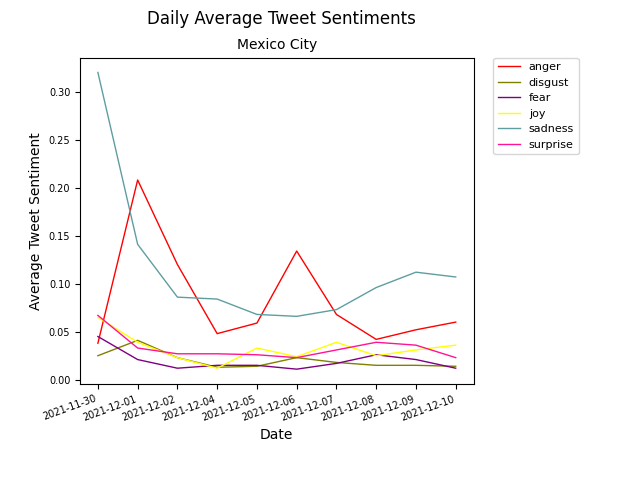

In [52]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

plt.close()
df_cdmx.sort_values(by='date_day', inplace=True)

font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

colors = {"anger": "red", 
          "disgust": "olive", 
          "fear": "purple", 
          "joy": "yellow", 
          "sadness": "cadetblue", 
          "surprise": "deeppink"}

#exclude "other"
for s in ["anger", "disgust", "fear", "joy", "sadness", "surprise"]:
    plt.plot('date_day', s, data=df_cdmx, color=colors[s],  linewidth=1)
    
    
# show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 8})

plt.suptitle('Daily Average Tweet Sentiments', x=.44, fontsize=12)
plt.title('Mexico City', fontsize=10)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Average Tweet Sentiment', fontdict=font)

# format the x and y ticks
plt.xticks(rotation=20, horizontalalignment='right', fontsize=7)
plt.yticks(fontsize=7)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(right=.74)


# show graph
plt.show()
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

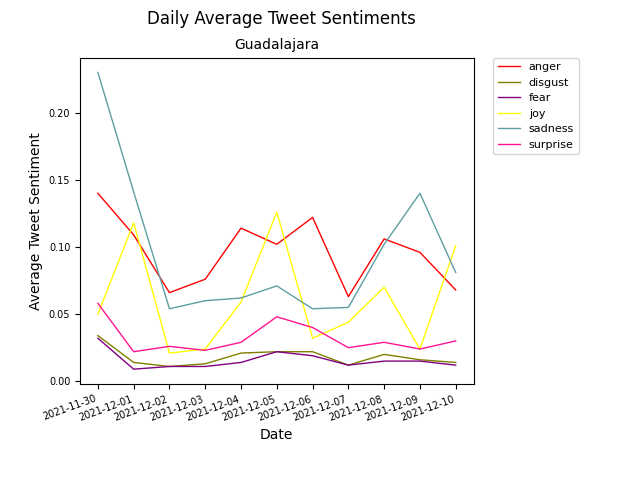

In [53]:
import matplotlib.font_manager as font_manager

plt.close()

df_gdl.sort_values(by='date_day', inplace=True)
#restrict to same data range as above
df_gdl = df_gdl.iloc[1:, :]

font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

colors = {"anger": "red", 
          "disgust": "olive", 
          "fear": "purple", 
          "joy": "yellow", 
          "sadness": "cadetblue", 
          "surprise": "deeppink"}

#exclude "other"
for s in ["anger", "disgust", "fear", "joy", "sadness", "surprise"]:
    plt.plot('date_day', s, data=df_gdl, color=colors[s],  linewidth=1)
    
    
# show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 8})

plt.suptitle('Daily Average Tweet Sentiments', x=.44, fontsize=12)
plt.title('Guadalajara', fontsize=10)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Average Tweet Sentiment', fontdict=font)

# format the x and y ticks
plt.xticks(rotation=20, horizontalalignment='right', fontsize=7)
plt.yticks(fontsize=7)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(right=.74)

# show graph
plt.show()
%matplot plt
